## K-Competitive Autoencoder for Text (KATE)
(KATE) is a topic modeling approach that uses an autoencoder to extract the underlying topics from text data.

Unfortunately, scikit-learn does not have a built-in implementation of KATE. To implement KATE in Python 3, you would have to use another library or write your own implementation.

https://github.com/hugochan/KATE

In [1]:
import tensorflow as tf
import numpy as np

2023-02-14 11:18:58.524796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
from tqdm.notebook import tqdm
tqdm.pandas()

import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS


from sklearn.decomposition import TruncatedSVD, PCA, NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import re
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def clean_text(sentence):
    # remove non alphabetic sequences
    pattern = re.compile(r'[^a-z]+')
    sentence = sentence.lower()
    sentence = pattern.sub(' ', sentence).strip()
    # Tokenize
    word_list = word_tokenize(sentence)
    
    # stop words
    stopwords_list = set(stopwords.words('english'))
    # puctuation
    punct = set(string.punctuation)
    # remove stop words
    word_list = [word for word in word_list if word not in stopwords_list]
    # remove very small words, length < 3
    # they don't contribute any useful information
    word_list = [word for word in word_list if len(word) > 2]
    # remove punctuation
    word_list = [word for word in word_list if word not in punct] 
    # stemming
    ps  = PorterStemmer()
    word_list = [ps.stem(word) for word in word_list]  
    # lemmatize
    lemma = WordNetLemmatizer()
    word_list = [lemma.lemmatize(word) for word in word_list]
    # list to sentence
    sentence = ' '.join(word_list)   
    return sentence


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import re
import string

from sklearn.decomposition import TruncatedSVD, PCA, NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# clean text data

# Load text data into a pandas dataframe
df = pd.read_csv('all_respones_for_all_interviewees_respones_LIWC_words_V2.csv')
df['response'] = df['response'].progress_apply(lambda x: clean_text(str(x)))
# Pre-processing the text data
text = df['response'].values
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(text)

# Define the autoencoder architecture
inputs = tf.keras.layers.Input(shape=(X.shape[1],))
encoded = tf.keras.layers.Dense(512, activation='relu')(inputs)
encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(32, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(16, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(32, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(64, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(256, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(X.shape[1], activation='sigmoid')(decoded)
autoencoder = tf.keras.models.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(X.toarray(), X.toarray(), epochs=10, batch_size=128, validation_split=0.2)

# Extract the encoding layer
encoder = tf.keras.models.Model(inputs, encoded)
encoded_data = encoder.predict(X.toarray())

# Reduce the encoded data to 2 dimensions using PCA
pca = PCA(n_components=2)
encoded_data = pca.fit_transform(encoded_data)


  0%|          | 0/17953 [00:00<?, ?it/s]

2023-02-14 11:19:50.249373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
113/113 [==============================] - 5s 36ms/step - loss: 0.1019 - val_loss: 0.0108
Epoch 2/10
113/113 [==============================] - 3s 30ms/step - loss: 0.0095 - val_loss: 0.0101
Epoch 3/10
113/113 [==============================] - 4s 32ms/step - loss: 0.0092 - val_loss: 0.0100
Epoch 4/10
113/113 [==============================] - 4s 31ms/step - loss: 0.0091 - val_loss: 0.0099
Epoch 5/10
113/113 [==============================] - 3s 31ms/step - loss: 0.0091 - val_loss: 0.0099
Epoch 6/10
113/113 [==============================] - 4s 31ms/step - loss: 0.0090 - val_loss: 0.0092
Epoch 7/10
113/113 [==============================] - 3s 30ms/step - loss: -16686230.0000 - val_loss: -494807904.0000
Epoch 8/10
113/113 [==============================] - 3s 31ms/step - loss: -38638096220160.0000 - val_loss: -388541532078080.0000
Epoch 9/10
113/113 [==============================] - 3s 30ms/step - loss: -38657037831241728.0000 - val_loss: -225182627068379136.0000
Epoch 10/1

In [4]:
from sklearn.cluster import KMeans
number_of_topics= 10
kmeans = KMeans(n_clusters=number_of_topics, random_state=0)
clusters = kmeans.fit_predict(encoded_data)

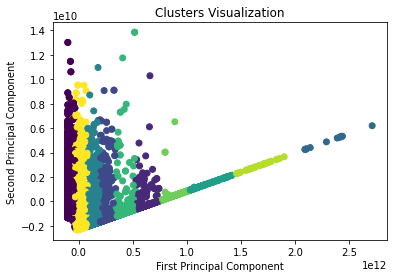

In [5]:
import matplotlib.pyplot as plt

# Plot the data points
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=clusters, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clusters Visualization')
plt.show()

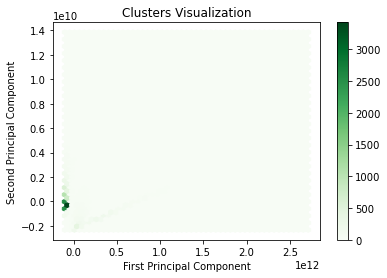

In [6]:
import matplotlib.pyplot as plt

# Plot the data points as a hexbin plot
plt.hexbin(encoded_data[:, 0], encoded_data[:, 1], gridsize=50, cmap='Greens') # cmap='Blues'
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clusters Visualization')
plt.colorbar()
plt.show()


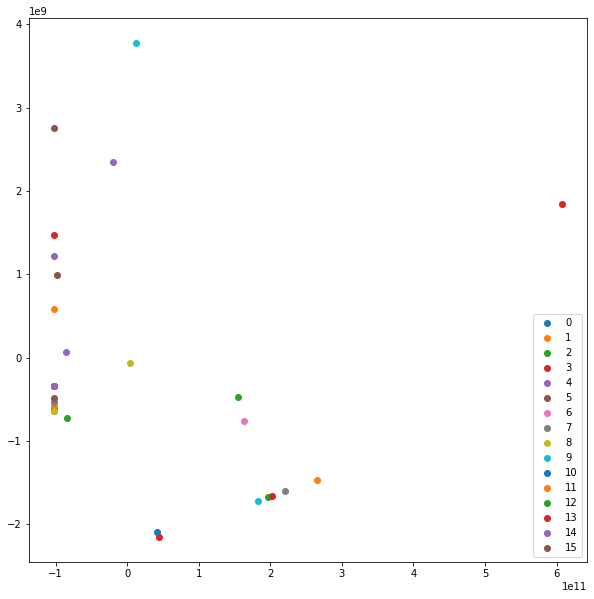

Topic 0 :
achiev
activ
adult
age
access
alarm
afternoon
abund
aggress
acid
ace
afterward
ahead
abl
add


Topic 1 :
activ
ahead
aggress
action
achiev
age
adult
advic
access
abund
abl
agit
ace
acquir
add


Topic 2 :
ad
alakazam
aftershock
aha
accept
airpod
absolut
afraid
actual
acceler
abit
ach
advantag
academ
aim


Topic 3 :
alarm
aggress
aid
activ
ahead
agit
afterward
adjust
age
ace
afternoon
abstract
advic
accur
access


Topic 4 :
afraid
accept
aha
academ
ad
alakazam
acceler
affect
advanc
absolut
aim
abit
actual
advantag
adrenalin


Topic 5 :
activ
adrenalin
afternoon
afterward
abstract
accomplish
aback
aha
action
accumul
access
adult
afraid
adapt
ador


Topic 6 :
age
action
access
abl
afternoon
add
acquir
ahead
activ
accur
abund
alarm
abstract
aid
ace


Topic 7 :
abund
abl
activ
abstract
aid
adult
aggress
agit
ahead
accur
afternoon
afterward
alarm
adjust
achiev


Topic 8 :
academ
ador
ahead
air
accumul
accident
abil
adult
agit
adhd
abstract
age
abund
abus
actual


Topic 9 :
actual
ac

In [7]:
# Plot the top 15 topics
plt.figure(figsize=(10, 10))
for i in range(16):
    x = encoded_data[df['ids'] == i, 0]
    y = encoded_data[df['ids'] == i, 1]
    plt.scatter(x, y, label=str(i))
plt.legend()
plt.show()

# Visualize the topics' corresponding words
word_index = vectorizer.vocabulary_
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

topic_words = autoencoder.layers[-8].get_weights()[0]
topic_words = np.dot(topic_words, np.diag(1 / np.linalg.norm(topic_words, axis=0)))
top_words = np.argsort(-topic_words, axis=0)[:15]

for i in range(10):
    print("Topic", str(i), ":")
    for j in range(15):
        print(reverse_word_index[top_words[j][i]])
    print("\n")

In [13]:
new_file = open('Kate_topic_modeling.csv','a')
new_file.write('Topic words'+'\n')
for i in range(10):
    #print("Topic", str(i), ":")
    new_file.write('topic'+str(i)+'\n')
    for j in range(15):
        new_file.write(reverse_word_index[top_words[j][i]]+'\n')

In [9]:
display(top_words)

array([[23, 29, 31, 63, 45, 29, 49,  8, 10, 30, 47,  7,  0,  1, 54, 56,
        51, 11,  0, 63, 62,  3,  8,  7, 20, 56, 50, 60,  3, 49,  3, 34],
       [29, 56, 62, 50, 13, 38, 28,  3, 37, 10, 30, 48, 49, 45, 38, 24,
        14, 45, 43, 29, 44, 20,  7, 56, 56, 33, 28,  2,  7, 26, 20, 31],
       [39, 50, 47, 57, 55, 46, 14, 29, 56, 44, 62,  3, 23, 56, 42, 42,
        26, 57, 45, 14, 60,  8, 63, 15, 50, 42, 14, 38, 50,  8, 50, 11],
       [49, 28, 55, 29, 10, 48,  3,  7, 59,  5, 55, 57, 18, 33,  1, 46,
        24, 61, 15, 42, 30, 50, 39, 46, 24, 14,  7, 44, 28, 50, 33, 52],
       [14, 23, 13, 56, 31,  7, 46, 57, 19, 11,  5, 63, 61,  2, 17, 39,
        29, 38, 30, 26, 22,  7, 57, 11, 35, 51,  3, 58, 32, 51, 32, 30],
       [63, 49, 60, 51, 62, 17, 33, 39, 16,  2, 10, 49,  1,  3,  3, 51,
        39, 58, 62, 46, 47, 42, 21,  8,  8, 23, 23, 47, 46, 21, 46, 59],
       [46, 39,  5, 48, 11,  0, 26, 50,  1, 41,  2, 33, 12, 58, 53, 63,
        48,  2, 16, 56,  2, 29, 28, 60, 42, 21, 33, 10, 33

In [72]:
# Find the closest topic for each response
topic_words = autoencoder.layers[-8].get_weights()[0]
topic_words = np.dot(topic_words, np.diag(1 / np.linalg.norm(topic_words, axis=0)))
print(topic_words)
print(topic_words.shape)

response_vectors = vectorizer.transform(df['response'].values).toarray()
print(response_vectors)

# similarity_scores = np.dot(response_vectors, topic_words)
# closest_topic = np.argmax(similarity_scores, axis=1)

# Add the closest topic as a column in the dataframe
# df['topic'] = closest_topic


[[ 0.02291146 -0.09009414 -0.03612646 ... -0.02535846 -0.00121218
   0.073716  ]
 [ 0.00856531 -0.05615208 -0.00681305 ...  0.01647398  0.00239451
  -0.10299393]
 [ 0.13062775  0.1168435  -0.02512821 ...  0.18665013  0.16589926
   0.1587692 ]
 ...
 [ 0.17717704 -0.03774509  0.03307384 ...  0.16386957  0.15403643
   0.1693769 ]
 [ 0.1663728   0.07866604  0.04127891 ...  0.13192077  0.17640507
  -0.05645696]
 [-0.17212607 -0.04385412  0.25656855 ... -0.16603011 -0.17141783
   0.05962992]]
(64, 32)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## To determine the best number of topics, 
you can use a technique called the elbow method. The idea behind this method is to plot the explained variance of the topic models against the number of topics, and pick the number of topics where the explained variance starts to level off.


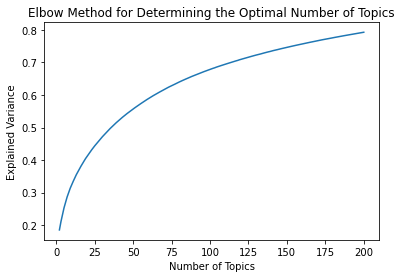

In [8]:
# Get the explained variance for different numbers of topics
def get_explained_variance(vectorizer, X, num_topics):
    svd = TruncatedSVD(n_components=num_topics)
    svd_fit = svd.fit(X)
    return svd_fit.explained_variance_ratio_.sum()

num_topics_array = np.arange(2, 201)
explained_variance_array = [get_explained_variance(vectorizer, X, num_topics) for num_topics in num_topics_array]

# Plot the explained variance against the number of topics
plt.plot(num_topics_array, explained_variance_array)
plt.xlabel('Number of Topics')
plt.ylabel('Explained Variance')
plt.title('Elbow Method for Determining the Optimal Number of Topics')
plt.show()


In [62]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# import re
# import string

# from sklearn.decomposition import TruncatedSVD, PCA, NMF, LatentDirichletAllocation
# from sklearn.manifold import TSNE
# from nltk.tokenize import word_tokenize
# from nltk.stem.porter import PorterStemmer
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# # clean text data

# # Load text data into a pandas dataframe
# df = pd.read_csv('all_respones_for_all_interviewees_respones_LIWC_words_V2.csv')
# df['response'] = df['response'].progress_apply(lambda x: clean_text(str(x)))
# # Pre-processing the text data
# text = df['response'].values
# vectorizer = CountVectorizer(stop_words='english')
# X = vectorizer.fit_transform(text)

# # Define the autoencoder architecture
# inputs = tf.keras.layers.Input(shape=(X.shape[1],))
# encoded = tf.keras.layers.Dense(512, activation='relu')(inputs)
# encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
# encoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
# encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
# encoded = tf.keras.layers.Dense(32, activation='relu')(encoded)
# encoded = tf.keras.layers.Dense(16, activation='relu')(encoded)
# decoded = tf.keras.layers.Dense(32, activation='relu')(encoded)
# decoded = tf.keras.layers.Dense(64, activation='relu')(decoded)
# decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
# decoded = tf.keras.layers.Dense(256, activation='relu')(decoded)
# decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
# decoded = tf.keras.layers.Dense(X.shape[1], activation='sigmoid')(decoded)
# autoencoder = tf.keras.models.Model(inputs, decoded)
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# # Train the autoencoder
# autoencoder.fit(X.toarray(), X.toarray(), epochs=10, batch_size=128, validation_split=0.2)

# # Extract the encoding layer
# encoder = tf.keras.models.Model(inputs, encoded)
# encoded_data = encoder.predict(X.toarray())

# # Reduce the encoded data to 2 dimensions using PCA
# pca = PCA(n_components=2)
# encoded_data = pca.fit_transform(encoded_data)

# # Visualize the topics' corresponding words
# word_index = vectorizer.vocabulary_
# reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# topic_words = autoencoder.layers[-8].get_weights()[0]
# topic_words = np.dot(topic_words, np.diag(1 / np.linalg.norm(topic_words, axis=0)))
# top_words = np.argsort(-topic_words, axis=0)[:15]

# for i in range(20):
#     print("Topic", str(i), ":")
#     for j in range(15):
#         print(reverse_word_index[top_words[j][i]])
#     print("\n")

    
# # Find the closest topic for each response
# topic_words = autoencoder.layers[-8].get_weights()[0]
# topic_words = np.dot(topic_words, np.diag(1 / np.linalg.norm(topic_words, axis=0)))
# print(topic_words)

# response_vectors = vectorizer.transform(df['response'].values).toarray()
# print(response_vectors)
# similarity_scores = np.dot(response_vectors, topic_words)
# closest_topic = np.argmax(similarity_scores, axis=1)

# # Add the closest topic as a column in the dataframe
# df['topic'] = closest_topic